In [17]:
#dep: https://www.colour-science.org/installation-guide/

#This program is based largely on the work of Hiroshi Yokoyama and Wei Chen of Kent State University

#Wei Chen & Hiroshi Yokoyama (2020) Rapid thickness mapping of free-standing smectic films using colour information of reflected light, Liquid Crystals, DOI: 10.1080/02678292.2020.1825843

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

import pandas as pd
import colour

import cv2

from colour.plotting import *
%matplotlib inline

In [18]:
%matplotlib inline

Let's start by initializing some constants for our material, and using them to create a reflectivity distribution based on material thickness.

Text(0, 0.5, 'Intensity')

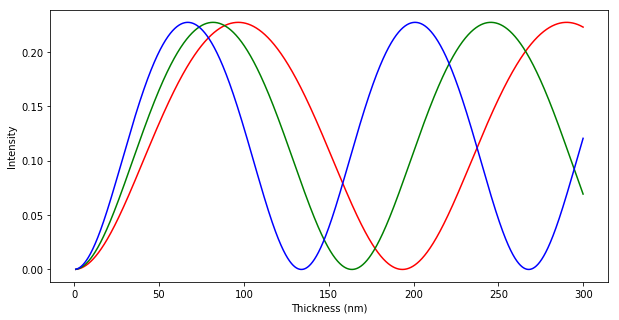

In [19]:
n = 1.68; #Index of refraction for mx12160
L = 3.1; #Thickness of a single mx12160 layer in nm
Lr = 650; #wavelength in nm for red light
Lg = 550; #wavelength in nm for green light
Lb = 450; #wavelength in nm for blue light
cosT = 1; #cosine of the internal angle of reflection; 0 degrees for our setup

h = np.array([]); #Range of possible thicknesses
rang = 300; #range of possible thicknesses, to restrict false positives
for x in range(10,10*rang,1):
    h = np.append(h,float(x/10))

r0 = (n-1)/(n+1)
Br = (4*(math.pi)*n*h)/Lr #Beta for the red spectrum, with h factored out
Bg = (4*(math.pi)*n*h)/Lg #Beta for the green spectrum, with h factored out
Bb = (4*(math.pi)*n*h)/Lb #Beta for the blue spectrum, with h factored out

BHr = np.array([Br,h]) 
BHr = np.transpose(BHr) #List of beta values for varying values of thickness, h, for red spectrum

BHg = np.array([Bg,h])
BHg = np.transpose(BHg)#List of beta values for varying values of thickness, h, for green spectrum

BHb = np.array([Bb,h])
BHb = np.transpose(BHb)#List of beta values for varying values of thickness, h, for blue spectrum

Rr = 2*(1-np.cos(Br))/(np.power(r0,2)+np.power(r0,-2)-2*np.cos(Br))

Rg = 2*(1-np.cos(Bg))/(np.power(r0,2)+np.power(r0,-2)-2*np.cos(Bg))

Rb = 2*(1-np.cos(Bb))/(np.power(r0,2)+np.power(r0,-2)-2*np.cos(Bb))


fig,ax = plt.subplots(figsize = (10,5))
ax.plot(h, Rr, color='red')
ax.plot(h, Rg, color='green')
ax.plot(h, Rb, color='blue')
ax.set_xlabel('Thickness (nm)')
ax.set_ylabel('Intensity')

Text(0, 0.5, 'Normalized Color Coordinates')

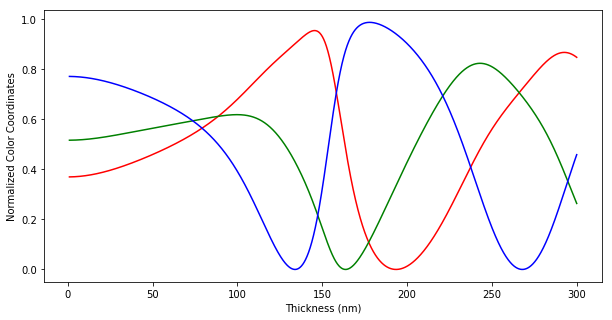

In [20]:
#This normalizes the functions by removing the intensity from the equation, simplifying to pure RGB data
norm = np.sqrt(np.power(Rr,2)+np.power(Rg,2)+np.power(Rb,2))
NRr = Rr/norm
NRg = Rg/norm
NRb = Rb/norm

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(h, NRr, color='red')
ax.plot(h, NRg, color='green')
ax.plot(h, NRb, color='blue')
ax.set_xlabel('Thickness (nm)')
ax.set_ylabel('Normalized Color Coordinates')

## Determining the reflectivity of a film based on color data

In [21]:
#Insert your image here and declare it as the variable im so that the program can read it. 

prefix = "C:/Users/keith/Desktop/filmThickness-main/filmThickness-main/filmThickness-main/Data/"
fileName = prefix + 'islands1 8CB 5-20.tif'

im = plt.imread(fileName)

In [22]:
#This brings up a pop-up window of the film and lets you select the are of the film you want to measure from by hand. 

coords = []
def click_event(event, x, y, flags, params): 
    if event == cv2.EVENT_LBUTTONDOWN:
        global coords
        coords = [int(y), int(x)]
        print(coords)
        
while(1):
    img = cv2.imread(fileName, 1)
    cv2.imshow('image', img)
    cv2.setMouseCallback('image', click_event)
    k = cv2.waitKey(33)
    if coords != []:
        cv2.destroyAllWindows()
        break

[310, 514]


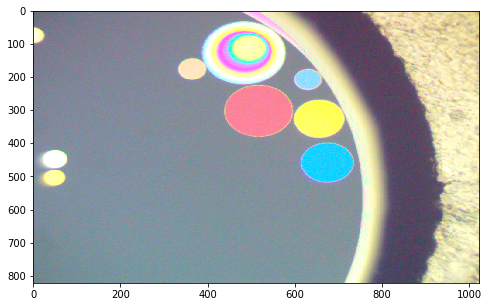

In [23]:
img,rx = plt.subplots(figsize = (8,5))
rx.imshow(im, aspect='auto', cmap='gray')

In [24]:
sampleRange = 50 #This is the width/height of the square region centered at the chosen coordinates for which the color information is sampled and averaged

edge1 = int(coords[0] - (sampleRange/2))
edge2 = int(coords[1] - (sampleRange/2))

island_coords = [im[edge1,edge2]]

for i in range(sampleRange):
    for j in range(sampleRange):
        coords = im[edge1 + i, edge2 + j]
        island_coords = np.append(island_coords, [coords], axis=0)

island_coords = np.transpose(island_coords)
if np.average(island_coords[0]) <= 1:
    if np.average(island_coords[1]) <= 1:
        if np.average(island_coords[2]) <= 1:
            island_px = [(np.average(island_coords[0])), (np.average(island_coords[1])), (np.average(island_coords[2]))]
else:
        island_px = [int(np.average(island_coords[0])), int(np.average(island_coords[1])), int(np.average(island_coords[2]))]

print(island_px)

[252, 130, 154]


[252, 130, 154]


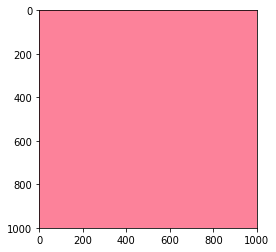

In [25]:
fig,ax=plt.subplots()
exColor = island_px
print(exColor)
exFilmColor = exColor * np.ones((1000,1000,3), dtype=int)
ax.imshow(exFilmColor)

#This shows what color was selected from the image. 

Now that we have the color coordinates from our image, let's try and fit it to the graph for reflectivity we found earlier! To do this, we first need a map that goes from color data to reflectivity; we can do this using the black glass images we took, which have a known reflectivity of 0.04. 

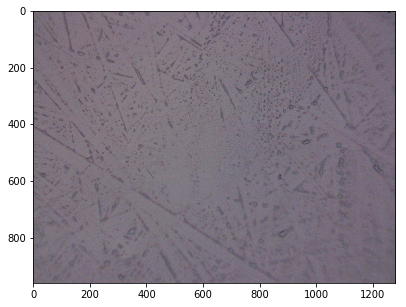

In [26]:
#This is where we import our reference image for the black glass, which is used to map the camera coordinates to pure color intensity. You can change what the reference image is below by replacing referenceName with the file you want to use!

BGR = .04
referenceName = prefix + 'Black Glass Test.jpg'

blackGlass = plt.imread(referenceName)
fig,ax=plt.subplots(figsize=(10,5))
ax.imshow(blackGlass)

In [27]:

coordsbg = []
def click_event2(event, x, y, flags, params): 
    if event == cv2.EVENT_LBUTTONDOWN:
        global coordsbg
        coordsbg = [int(y), int(x)]
        print(coordsbg)
        

while(1):
    imgbg = cv2.imread(referenceName, 1)
    cv2.imshow('image', imgbg)
    cv2.setMouseCallback('image', click_event2)
    k = cv2.waitKey(33)
    if coordsbg != []:
        cv2.destroyAllWindows()
        break

bg_coord = coordsbg
if np.average(bg_coord[0]) <= 1:
    if np.average(bg_coord[1]) <= 1:
        if np.average(bg_coord[2]) <= 1:
            bg_clear = blackGlass[(bg_coord[0]), (bg_coord[1])]
else:
    bg_clear = blackGlass[int(bg_coord[0]), int(bg_coord[1])]
print(bg_clear)

redSlope = (1+BGR)/bg_clear[0] #This multiplied by a red coordinate in RGB space gives the red reflectivity

greenSlope = (1+BGR)/bg_clear[1] #This multiplied by a green coordinate in RGB space gives the green reflectivity

blueSlope = (1+BGR)/bg_clear[2] #This multiplied by a blue coordinate in RGB space gives the blue reflectivity

slopes = [redSlope, greenSlope, blueSlope]

[515, 139]
[128 123 130]


[128 123 130]


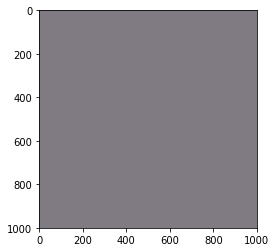

In [28]:
fig,ax=plt.subplots()
exBGColor = bg_clear
print(exBGColor)
exBGFilmColor = exBGColor * np.ones((1000,1000,3), dtype=int)
ax.imshow(exBGFilmColor, cmap='gray', vmin=0, vmax=255)

#This shows what color was selected as the reference for the black glass. 

## Determining Film Thickness from Reflectivity

In [29]:
#This extracts the color information for our image and converts it to channel-specific intensity information, then normalizes them according to the plots found above. The reason it is done in three steps is to add later support for sampling thickness information at multiple locations in one step; for right now, normd1 is the only value that survives past this step. 

island_1 = island_px

refl1 = np.multiply(slopes, island_1)

norm1 = np.sqrt(np.power(refl1[0],2)+np.power(refl1[1],2)+np.power(refl1[2],2))

normd1 = refl1/norm1

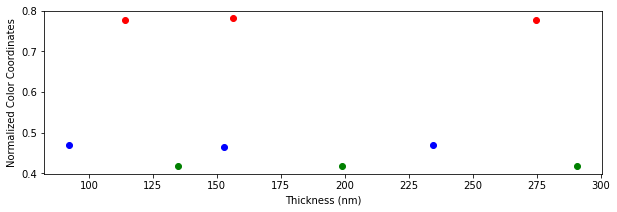

In [30]:
#This combines the above colour information with the normalized color vs thickness plots we made earlier, and plots the points of intersection; the points which are closest together represent the "true" thickness of the film. This can be thought of as the "closest approach" of a trajectories on the surface of a sphere to a given point in color space, but I've found it's easier to visualize like this. 

fig2,ax1= plt.subplots(nrows=1,ncols=1, figsize = (10,3))

if normd1[0] > 0.95:
    normd1[0] = 0.95
if normd1[0] < 0.001:
    normd1[0] = 0.001

if normd1[1] > 0.95:
    normd1[1] = 0.95
if normd1[1] < 0.001:
    normd1[1] = 0.001

if normd1[2] > 0.95:
    normd1[2] = 0.95
if normd1[2] < 0.001:
    normd1[2] = 0.001

id1R = np.argwhere(np.diff(np.sign(NRr - np.ones(10*(rang-1))*normd1[0]))).flatten()
id1G = np.argwhere(np.diff(np.sign(NRg - np.ones(10*(rang-1))*normd1[1]))).flatten()
id1B = np.argwhere(np.diff(np.sign(NRb - np.ones(10*(rang-1))*normd1[2]))).flatten()
ax1.plot(h[id1R], NRr[id1R], 'ro')
ax1.plot(h[id1G], NRg[id1G], 'go')
ax1.plot(h[id1B], NRb[id1B], 'bo')
ax1.set_xlabel('Thickness (nm)')
ax1.set_ylabel('Normalized Color Coordinates')

isl1RInters = [h[id1R], NRr[id1R]]
isl1GInters = [h[id1G], NRg[id1G]]
isl1BInters = [h[id1B], NRb[id1B]]

In [31]:
points1R = []
points1G = []
points1B = []

R1xs = isl1RInters[0]
G1xs = isl1GInters[0]
B1xs = isl1BInters[0]

for i in range(0,len(R1xs)):
    for j in range(0,len(G1xs)):
        point = np.abs(R1xs[i]-G1xs[j])
        points1R.append(point)
    
mindif1r = np.amin(points1R)
posh1r = points1R.index(mindif1r)
print(posh1r)

l = 0
g = 0
r = 0
while l != posh1r:
    if g < len(G1xs) - 1:
        g += 1
        l += 1
    else:
        g = 0
        r += 1
        l += 1
    continue

print(l, r, g)

print("i:",r, "j:",g)
print(R1xs[r],G1xs[g])

8
8 2 2
i: 2 j: 2
274.7 290.7


In [32]:
if np.abs(R1xs[r]-G1xs[g]) <= 20:
    avgThick = (R1xs[r]+G1xs[g])/2
    print("The film is ", avgThick, "nm, or ", int(avgThick/L), "layers, thick.")
else:
    print("Significant variation in thickness. Possible thicknesses are:")
    print(R1xs[r], "nm, ", int(R1xs[r]/L), "layers")
    print(G1xs[g], "nm, ", int(G1xs[g]/L), "layers")

The film is  282.7 nm, or  91 layers, thick.


## Summary
Basically, this program works using the method laid down in Hiroshi's paper on determining film thickness from color distribution data. It operates by using the material properties to calculate a reflectivity spread for the red, blue, and green spectra and normalizes it to remove overall film brightness from consideration, then looks for solutions to the this system of equations that matches the reflectivities of the film. 

The reflectivities of the film are determined using a baseline image of a piece of black glass, which has a known reflectivity of 4%; this image can be split into it's three color channels (RGB) and this gives us a linear mapping for each color channel of the brightness to the reflectivity in that color range. This can be applied to the raw color data taken from an image of a film, giving us the absolute reflectivities; by normalizing each of these in the same method as above, we get three constant reflectivities which can be imposed on top of our reflectivity spread. The intersection points of these lines with the reflectivity spreads are then plotted. 

Each triplet of red, green, and blue points is then considered, and the triplet with the smallest total distance between them is considered the solution to the system. Each of these data points then has it's x-axis data extracted, giving 3 different thickness measurements. If all of these are equal to within 10nm, then only one of the values is reported and this is considered the thickness of the film. If they differ by a significant amount, then a message will appear saying that there is a significant variation in thickness, and all possible thickness values will be reported. This shouldn't happen unless the true thickness of the film exceeds the range provided.  